<a href="https://colab.research.google.com/github/MaryObr/coursework/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Первичный сбор данных на otzovik.ru


In [ ]:
# !pip install selenium
# !apt install chrome
# !pip install fake_useragent
# from selenium import webdriver
# from selenium.webdriver.firefox.options import Options
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.by import By
# from fake_useragent import UserAgent
# from selenium.webdriver.support.wait import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import ElementClickInterceptedException
# from selenium.common.exceptions import StaleElementReferenceException
# from selenium.common.exceptions import TimeoutException
!pip install nltk
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
!pip install tqdm
from tqdm import tqdm
from google.colab import files
import sqlite3
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
conn = sqlite3.connect('reviews_general.db')
c = conn.cursor()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sismetanin/rubert-ru-sentiment-rusentiment")
model = AutoModelForSequenceClassification.from_pretrained("sismetanin/rubert-ru-sentiment-rusentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

In [ ]:
options = Options()
options.add_argument('--headless')
ua = UserAgent()
user_agent = "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"
options.add_argument(f'user-agent={user_agent}')

Определение оптимального ограничения длины отзыва

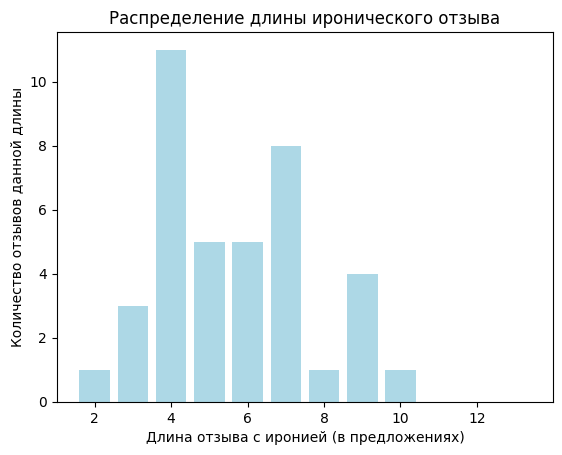

In [ ]:
length = {}
for sarc in sarcastic:
  le = len(sent_tokenize(sarc))
  if le in length.keys():
    length[le]+=1
  else:
    length[le]=0

plt.bar(list(length.keys()), list(length.values()), color='lightblue')
plt.title('Распределение длины иронического отзыва')
plt.ylabel('Количество отзывов данной длины')
plt.xlabel('Длина отзыва с иронией (в предложениях)')
plt.show() #берём ограничение 5 по этому распределению по 30 отзывам на все товары

In [ ]:
def sentiment(sent:str):#определение класса сентимента предложения
  inputs = tokenizer(sent, return_tensors='pt')
  with torch.no_grad():
      logits = model(**inputs).logits
  predicted_class_id = logits.argmax().item()
  return predicted_class_id #0 -- отрицательный, 1 -- нейтральный, 2 -- положительный

In [ ]:
def polozh_check(text): # проверка на положительность
  sent_text = sent_tokenize(text)
  if len(sent_text)>5:
    return False
  if sentiment(text)!=0:
    return True
  return False

In [ ]:
def data_pos(link): #краулеринг положительных отзывов
  driver = webdriver.Firefox(options=options)
  driver.get(link)
  search = []
  id = 0
  while len(set(search)) <= 100:
    li = [element.text.replace('Читать отзыв', '') for element in list(driver.find_elements(By.CLASS_NAME, "review-snippet")) if polozh_check(element.text)]
    try:
      search_btn = driver.find_element(By.CLASS_NAME, 'my_pagination')
      search_btn.click()
    except ElementClickInterceptedException:
      driver.implicitly_wait(5)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    search.extend(li)
  search = set(search)
  for i in search: #добавление положительных отзывов в датасет
    c.execute('CREATE TABLE IF NOT EXISTS Positives (id_n integer, text_n text)')
    record = (id, i)
    c.execute("INSERT INTO Positives VALUES (?, ?)", record)
    conn.commit()
    id += 1

In [ ]:
# список положительных ссылок
polozh = ['https://www.otzyvru.com/dpd?sort=rating_desc',
          'https://www.otzyvru.com/rossiyskie-jeleznye-dorogi?sort=rating_desc',
          'https://www.otzyvru.com/rostelekom?sort=rating_desc',
          'https://www.otzyvru.com/yandeks-taksi?sort=rating_desc',
          'https://www.otzyvru.com/detskiy-mir?sort=rating_desc',
          'https://www.otzyvru.com/mts?sort=rating_desc',
          'https://www.otzyvru.com/match-tv?sort=rating_desc',
          'https://www.otzyvru.com/sdek?sort=rating_desc',
          'https://www.otzyvru.com/ozonru?sort=rating_desc',
          'https://www.otzyvru.com/avitoru?sort=rating_desc',
          'https://www.otzyvru.com/sbermarket?sort=rating_desc',
          'https://www.otzyvru.com/yandekseda?sort=rating_desc',
          'https://www.otzyvru.com/megafon?sort=rating_desc',
          'https://www.otzyvru.com/mebelnaya-fabrika-mnogo-mebeli?sort=rating_desc',
          'https://www.otzyvru.com/sberbank-rossii?sort=rating_desc',
          'https://www.otzyvru.com/wildberriesru?sort=rating_desc',
          'https://www.otzyvru.com/pleerru?sort=rating_desc',
          'https://www.otzyvru.com/golos-perviy-kanal?sort=rating_desc',
          'https://www.otzyvru.com/peredacha-60-minut?sort=rating_desc',
          'https://www.otzyvru.com/sovkombank?sort=rating_desc']

In [ ]:
for p in tqdm(polozh):
  data_pos(p)

100%|██████████| 20/20 [1:24:39<00:00, 253.96s/it]


In [ ]:
# список негативных ссылок
negative =['https://www.otzyvru.com/dpd?sort=rating_desc',
          'https://www.otzyvru.com/rossiyskie-jeleznye-dorogi?sort=rating_asc',
          'https://www.otzyvru.com/rostelekom?sort=rating_asc',
          'https://www.otzyvru.com/yandeks-taksi?sort=rating_asc',
          'https://www.otzyvru.com/detskiy-mir?sort=rating_asc',
          'https://www.otzyvru.com/mts?sort=rating_asc',
          'https://www.otzyvru.com/match-tv?sort=rating_asc',
          'https://www.otzyvru.com/sdek?sort=rating_asc',
          'https://www.otzyvru.com/ozonru?sort=rating_asc',
          'https://www.otzyvru.com/avitoru?sort=rating_asc',
          'https://www.otzyvru.com/sbermarket?sort=rating_asc',
          'https://www.otzyvru.com/yandekseda?sort=rating_asc',
          'https://www.otzyvru.com/megafon?sort=rating_asc',
          'https://www.otzyvru.com/mebelnaya-fabrika-mnogo-mebeli?sort=rating_asc',
          'https://www.otzyvru.com/sberbank-rossii?sort=rating_asc',
          'https://www.otzyvru.com/wildberriesru?sort=rating_asc',
          'https://www.otzyvru.com/pleerru?sort=rating_asc',
          'https://www.otzyvru.com/golos-perviy-kanal?sort=rating_asc',
          'https://www.otzyvru.com/peredacha-60-minut?sort=rating_asc',
          'https://www.otzyvru.com/sovkombank?sort=rating_asc']

In [ ]:
def sentence_sentiment(text): # проверка отзыва на саркастичность
  sent_text = sent_tokenize(text)
  if len(sent_text)>5:
      return False
  if sentiment(text)!=2: # общее настроение не положительное
    for sentence in sent_text:
      if sentiment(sentence) == 2: #при этом есть положительное предложение
        return True
  return False

In [ ]:
def data_neg_2(link,number): #краулеринг негативных отзывов
  driver = webdriver.Firefox(options=options)
  driver.get(link)
  ignored_exceptions=(ElementClickInterceptedException, StaleElementReferenceException,TimeoutException)
  wait = WebDriverWait(driver, timeout=10, ignored_exceptions=ignored_exceptions)
  for i in tqdm(range(300)):
    try:
      elem = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'my_pagination')))
      search_btn = driver.find_element(By.CLASS_NAME, 'my_pagination')
      search_btn.click()
    except (ElementClickInterceptedException, StaleElementReferenceException):
      driver.save_screenshot('screenie.png')
    except TimeoutException:
      driver.implicitly_wait(15)
  driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
  li = set([element.text.replace('Читать отзыв', '') for element in list(driver.find_elements(By.CLASS_NAME, "review-snippet"))])
  with open(f'info{number}.txt', 'a+', encoding='utf-8') as f:
    for i in li:
      f.write(i+"|||")

In [ ]:
for site in range(len(negative)):
  data_neg_2(neg[site],site)
  files.download(f'info{10+site}.txt')

100%|██████████| 300/300 [18:07<00:00,  3.62s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [03:15<00:00,  1.54it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [01:42<00:00,  2.93it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [02:04<00:00,  2.40it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 300/300 [03:15<00:00,  1.53it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# выявление саркастических отзывов
for i in tqdm(range(1,18)):
  with open(f"info{i}.txt", 'r', encoding='utf-8') as f:
    lines = ''.join(f.readlines()).split("|||")
    new_lines = [line for line in lines if sentence_sentiment(line)]
  with open(f"sarcasm{i}.txt", 'w', encoding='utf-8') as f:
    for new in new_lines:
      f.write(new+"|||")
  files.download(f"sarcasm{i}.txt")


  0%|          | 0/17 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  6%|▌         | 1/17 [01:20<21:22, 80.17s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 12%|█▏        | 2/17 [25:20<3:39:59, 879.99s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 18%|█▊        | 3/17 [26:28<1:58:53, 509.50s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 24%|██▎       | 4/17 [27:43<1:13:13, 337.96s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 29%|██▉       | 5/17 [29:01<48:51, 244.28s/it]  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 35%|███▌      | 6/17 [30:49<36:17, 197.97s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 41%|████      | 7/17 [31:42<25:04, 150.45s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 47%|████▋     | 8/17 [32:31<17:43, 118.13s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 53%|█████▎    | 9/17 [54:58<1:06:59, 502.42s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 59%|█████▉    | 10/17 [58:07<47:19, 405.70s/it] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 65%|██████▍   | 11/17 [1:10:40<51:10, 511.70s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 71%|███████   | 12/17 [1:12:03<31:47, 381.49s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 76%|███████▋  | 13/17 [1:13:10<19:04, 286.09s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 82%|████████▏ | 14/17 [1:30:10<25:23, 507.73s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 88%|████████▊ | 15/17 [1:32:46<13:23, 401.74s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 94%|█████████▍| 16/17 [1:33:36<04:56, 296.09s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 17/17 [1:54:53<00:00, 405.47s/it]


In [ ]:
#добавление саркастических отзывов в датабазу
with open('sarcasm_general.txt', 'r', encoding='utf-8') as f:
  sarc = ''.join(f.readlines()).split("|||")
  id = 0
  for s in sarc:
    c.execute('CREATE TABLE IF NOT EXISTS Negatives (id_n integer, text_n text)')
    record = (id, s)
    c.execute("INSERT INTO Negatives VALUES (?, ?)", record)
    conn.commit()
    id += 1

# Обработка первичных данных

In [ ]:
import pandas as pd
from random import sample

In [ ]:
with open('sarcasm_general.txt') as sarc:
  reviews = ''.join(sarc.readlines()).split("|||")
  reviews = sample(reviews, 100)
  d = {'reviews':reviews,
       'is_sarcastic':[0]*len(reviews)}
  is_sarc = pd.DataFrame(data=d)
  is_sarc.to_csv("New.csv")



In [ ]:
import sqlite3
import pandas as pd

In [ ]:
cnx = sqlite3.connect('reviews_general.db')

df = pd.read_sql_query("SELECT * FROM Negatives", cnx)

In [ ]:
sarcastic_df = df[df['is_sarcastic'] == 1]
sarcastic_df.head(10)

,id,text_n,is_sarcastic
3,8,"""Наслаждаюсь"" поездкой в данном поезде ! Я кон...",1
4,1465,"""Посчастливилось"" попасть в эту помойку на раб...",1
5,43,"""Прекрасный"" сервис! Каждый раз заказывая буты...",1
6,73,"""Спасибо"", что строите мцд. Хоть в часы пик мо...",1
7,1935,"""Финалист"" Жора Русских петь не умеет совсем. ...",1
9,582,02.09.23 заказ выехал с Екатеринбурга до Брянс...,1
11,604,04.09 посылка отправлена из г.Феодосия в СПб. ...,1
12,619,06.02.2024 г. сотрудник принял от меня важное ...,1
15,385,"0890 позвонила, надо было решить вопрос по тар...",1
24,574,"13.01.2023 не работает программа, поэтому сего...",1


In [ ]:
sarcastic_df.to_csv("Sarcastic.csv")

ещё нужно сделать, чтобы не было ... (или заменить на ., или убрать такие предложения? но там бывает ирония)

# Добор саркастических данных

https://pravogolosa.net/otzyvcategory?page=show_category&catid=17&text_search=&order=0&ad_tipre=%D0%9D%D0%B5%D0%B3%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9


Предположительные "флажки" ироничности:

1) зачеркнутый текст + (зачеркнуто)/(нет)
2) типа/якобы + так называемый + видите ли
3) кавычки, мб еще восклицательные знаки (особенно если их много)
4) сильно выразительные слова типа "отлично/замечательно/классно/здорово/гениально/супер" + чудо + молодцы + поздравляю  + спасибо + вот так
5) повтор букв (типа вааау)??
6) смайлики! (по возможности смеющиеся) + скобочки

In [ ]:
import requests
!pip install fake_useragent
import time
import random
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
ua = UserAgent()
import urllib
from urllib.request import urlopen
!pip install tqdm
from tqdm import tqdm
!pip install emoji
!pip install emoji==1.7
from emoji import UNICODE_EMOJI
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=ac3d42ae7bfaf4b2a077f4a583683340c85650e9d3bc9b4e180aef57ba98fbb3
  Stored in directory: /root/.cache/pip/wheels/bd/22/e5/b69726d5e1a19795ecd3b3e7464b16c0f1d019aa94ff1c8578
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1


In [ ]:
session = requests.session()

In [ ]:
def get_neg(link:str, f:int, to:int):
  final_texts = []
  for n in tqdm(range(f, to, 20)): #всего 24140
    if n == 0:
      resp = session.get(link, headers={'User-Agent': ua.random})
    else:
      resp = session.get(f'{link}&start={n}', headers={'User-Agent': ua.random})
    page = resp.text
    soup = BeautifulSoup(page, "html.parser")
    div = soup.find_all('div', attrs = {'style': 'margin-bottom:8px;position:relative;'})
    for d in div:
      l = d.parent.find_all('a')
      hlink = [li.get('href') for li in l][-1].replace('Негативный', '%D0%9D%D0%B5%D0%B3%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9')
      tex = urlopen(f'https://pravogolosa.net{hlink}').read()
      soup = BeautifulSoup(tex, "html.parser")
      found = soup.find("div", attrs={'style': 'font-family:Verdana; font-size:15px;line-height:16pt;margin-top:15px;padding:0px 8px;'})
      final_texts.append(found)
    time.sleep(random.uniform(0.1, 0.5))
  reviews = [f.text.split('Подробнее')[0].strip("\t\t\t\t\t \n\t\t\t\t").strip('\n\n\n') for f in final_texts]
  return reviews

In [ ]:
link = 'https://pravogolosa.net/otzyvcategory?page=show_all&ad_tipre=%D0%9D%D0%B5%D0%B3%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9'

In [ ]:
rev = get_neg(link, 27000, 29000)
with open('new_neg19raw.txt', 'a+', encoding='utf-8') as f:
  for r in rev:
    f.write(r.strip())
    f.write("|||")
files.download('new_neg19raw.txt')

100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Сравним выделение саркастических отзывов:

In [ ]:
with open('new_neg18raw.txt', 'r', encoding='utf-8') as f: #получаем список сохраненных отзывов
  rev = ''.join(f.readlines()).split('|||')
  print(len(rev))

172


1. Старое определение предложения с позитивным сентиментом при общей непозитивности:

In [ ]:
new_sarc1 = []
for r in tqdm(rev):
  try:
    if sentence_sentiment(r):
      new_sarc1.append(r)
  except RuntimeError:
    print(r)

100%|██████████| 172/172 [00:59<00:00,  2.90it/s]


In [ ]:
with open('new_neg_old.txt', 'a+', encoding='utf-8') as f:
  for r in new_sarc1:
    f.write(r.strip())
    f.write("|||")

2. Проверка по правилам/закономерностям, выявленным при ручной разметке первичных отзывов:

In [ ]:
def new_sentence_sentiment(text:str):
  marked_words = set(["'", '"', 'типа', 'якобы', 'мол', 'так назывываем', 'видите ли',
                     'видете ли', 'вау', 'молодцы', 'классно', 'супер', 'отлично', 'гениально',
                     'замечательно', 'здорово', 'чудо', 'поздравляю', 'спасибо', 'шик', "))"
  ])
  sent_text = sent_tokenize(text)
  if len(sent_text)>5:
      return False
  if set(text).intersection(marked_words):
    return True
  if set(text).intersection(set(UNICODE_EMOJI)):
    return True

  return False

In [ ]:
new_sarc2 = [] #проведи через это new_neg и не забудь сохранить!
for r in rev:
  try:
    if new_sentence_sentiment(r):
      new_sarc2.append(r)
  except RuntimeError:
    print(r)

In [ ]:
with open('new_neg_new.txt', 'a+', encoding='utf-8') as f:
  for r in new_sarc2:
    f.write(r.strip())
    f.write("|||")

In [ ]:
gen_amount1 = 33+25+45+16+106+25+22+32+29+8+17+17+18+7+6
gen_amount2 = 98+95+45+46+246+143+89+178+149+89+105+168+171+171+78+86+47+14

gen_amount1, gen_amount2 #вторым методом получается больше отзывов, ожидается, что у него меньше точностьь

(406, 2018)

Записываем файлы в датабазу

In [ ]:
with open('new_neg_old.txt', 'r+', encoding='utf-8') as f:
  id = 0
  rev = set(''.join(f.readlines()).split('|||'))
  for i in rev: #добавление положительных отзывов в датасет
    c.execute('CREATE TABLE IF NOT EXISTS Negatives_2_old (id_n integer, text_n text)')
    record = (id, i)
    c.execute("INSERT INTO Negatives_2_old VALUES (?, ?)", record)
    conn.commit()
    id += 1

In [ ]:
with open('new_neg_new.txt', 'r+', encoding='utf-8') as f:
  id = 0
  rev = set(''.join(f.readlines()).split('|||'))
  for i in rev: #добавление положительных отзывов в датасет
    c.execute('CREATE TABLE IF NOT EXISTS Negatives_2_new (id_n integer, text_n text)')
    record = (id, i)
    c.execute("INSERT INTO Negatives_2_new VALUES (?, ?)", record)
    conn.commit()
    id += 1